# Statistical Learning - Resampling Methods

---

## Contents

### [Cross Validation](#cv)
   - [The Validation Set Approach](#validation-set)
   - [Leave-One-Out Cross-Validation](#loocv)
   - [K-Fold Cross-Validation](#k-fold)
   - [Bias-Variance Trade-Off for K-Fold Cross-Validation](#bias-variance-cv)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

np.set_printoptions(suppress=True)
%matplotlib inline
plt.style.use("fivethirtyeight")

---

## Datasets

In [2]:
auto = pd.read_csv("data/auto.csv", na_values = "?").dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


---

<a id="cv"></a>
# Cross Validation

I **Resampling Methods** sono degli strumenti indispensabili nel mondo dello *statistical learning*. Permettono di estrarre ripetutamente dei *sample* a partire da un *training set* e addestrare un modello su ciascuno di essi, così da ottenere informazioni sul modello addestrato che non sarebbe possibile ottenere utilizzando l'intero dataset originale.

Specifichiamo che il processo di valutazione delle performance di un modello prende il nome di **Model Assessment**, mentre il processo di selezione del corretto livello di flessibilità/complessità di un modello prende il nome di **Model Selection**.

---

<a id="validation-set"></a>
## The Validation Set Approach

Si divide il dataset in due parti di uguale dimensione: un **training set** ed un **validation set**, anche detto **hold-out set**. Il modello è addestrato sul *training set* ed è usato per costruire le *predicted responses* delle osservazioni nel *validation set*. Il **validation set error rate** risultante dall'esecuzione di queste *predict* rappresenta una stima del reale **test error rate**.

Facciamo un esempio con il dataset *Auto*, provando a predire *mpg* usando diverse potenze del predittore *horsepower*:

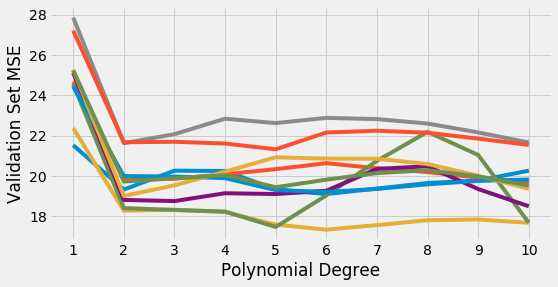

In [3]:
splits = 10
max_degree = 10
errors = {num: list() for num in range(1, splits + 1)}

for i in range(splits):
    X_train, X_test, Y_train, Y_test = train_test_split(
        auto[["horsepower"]], auto[["mpg"]], test_size = 0.5)
    X_poly_train = X_train.copy()
    X_poly_test = X_test.copy()
    for j in range(1, max_degree + 1):
        X_train_poly = PolynomialFeatures(degree = j).fit_transform(X_train)
        X_test_poly = PolynomialFeatures(degree = j).fit_transform(X_test)
        model = LinearRegression().fit(X_train_poly, Y_train)
        errors[i+1].append(mean_squared_error(Y_test, model.predict(X_test_poly)))
        
fig, ax = plt.subplots(figsize = (8, 4))
for i in range(splits):
    ax.plot(np.arange(1, max_degree + 1), errors[i + 1])
plt.xticks(np.arange(1, 11))
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation Set MSE")
plt.show()

Nonostante l'estrema variabilità dei risultati, dovuta alla randomicità dello split ripetuto del dataset, l'informazione che ricaviamo da quest'analisi è che il fit lineare (cioè il predittore *horsepower* senza alcun contributo polinomiale) non è adatto a modellare la relazione *predictor-response*.

Si nota solo un crollo del *MSE* in corrispondenza del termine quadratico, mentre le potenze superiori non sembrano suggerire ulteriori decrescite della metrica.

Il *validation set approach* è concettualmente semplice e facile da implementare, ma ha due problemi:

- La stima del *test error rate* costruita attraverso il *validation error rate* è altamente variabile, perché dipende fortemente da quali osservazioni sono incluse nel *training set* e quali finiscono nel *validation set*.


- Lo split 50/50 applicato sul dataset originale costringe i *learning method* ad essere addestrati su un numero di osservazioni minore rispetto al solito. Siccome i *learning method* tendono, in media, a performare peggio se addestrati con meno osservazioni, possiamo supporre che il *validation error rate* sia una *sovrastima* del reale *test error rate*.

---

<a id="loocv"></a>
## Leave-One-Out Cross-Validation

Anche la *LOOCV*, come il *validation set approach*, prevede lo split del dataset in due parti: si usa una singola osservazione come *validation set* e le restanti $n-1$ osservazioni come *training set*.

Dopo aver addestrato il modello sulle $n-1$ osservazioni del *training set*, si compie una sola *predict* sull'osservazione di *validation* e ne si calcola il corrispondente *MSE*.

Iterando il procedimento, scegliendo ad ogni *round* una diversa osservazione di *validation*, si ottengono $n$ misure di *MSE*. La stima del *test error* prodotta dalla *LOOCV* equivale alla media aritmetica di questi $n$ *MSE*.

$$\large CV_{(n)}=\frac{1}{n}\sum_{i=1}^{n}MSE_i$$

La *LOOCV* ha due vantaggi rispetto al *validation set approach*:
- Limita il bias associato al modello, dato che quest'ultimo è fittato sulla base di $n-1$ osservazioni e non $n/2$. Di conseguenza, la *LOOCV* non tende a *sovrastimare* il *test error*, ma a fornire una stima più accurata.


- Il numero di esecuzioni dell'intera procedura restituisce risultati sempre uguali, e non differenti in base allo specifico split applicato sul dataset originale.

Uno svantaggio evidente è la quantità di risorse computazionali necessarie per implementarlo, in quanto è necessario addestrare il modello $n$ volte.

Facciamo un esempio con il dataset *Auto*, provando a predire *mpg* usando una regressione polinomiale del predittore *horsepower*, usando solo il termine quadratico:

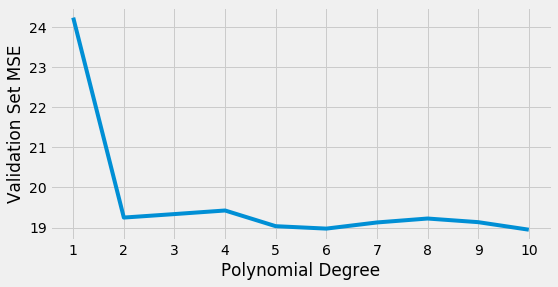

In [4]:
X = auto[["horsepower"]]
Y = auto[["mpg"]]

loocv = LeaveOneOut()
errors = list()
    
for j in range(1, max_degree + 1):
    poly_mse = list()
   
    for train_idx, test_idx, in loocv.split(X):
        X_train, X_test = np.array(X)[train_idx], np.array(X)[test_idx]
        Y_train, Y_test = np.array(Y)[train_idx], np.array(Y)[test_idx]
        X_train_poly = PolynomialFeatures(degree = j).fit_transform(X_train)
        X_test_poly = PolynomialFeatures(degree = j).fit_transform(X_test)
        model = LinearRegression().fit(X_train_poly, Y_train)
        poly_mse.append(mean_squared_error(Y_test, model.predict(X_test_poly)))
    errors.append(np.mean(poly_mse))

fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.arange(1, max_degree + 1), errors)
plt.xticks(np.arange(1, 11))
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation Set MSE")
plt.show()

Siamo riusciti ad ottenere una stima più precisa del *test error* per un fit quadratico, specialmente se la confrontatiamo con l'evidente variabilità dei risultati del *validation set approach*.

---

<a id="k-fold"></a>
## K-Fold Cross-Validation

La *KFCV* è la generalizzazione della *LOOCV*. Si divide il dataset in $k$ gruppi o **folds** di uguale dimensione. Si utilizza una di queste *fold* come *validation set*, e il *learning method* è addestrato sulle rimanenti $k-1$ *fold*.

Ripetendo il processo $k$ volte, usando ad ogni iterazione una diversa *fold* come *validation set*, si ottengono $k$ stime del *test error*. La stima totale della *KFCV* è la media aritmetica di questi $k$ *validation errors*.

$$\large CV_{(k)}=\frac{1}{k}\sum_{i=1}^{k}MSE_i$$

E' possibile osservare come la *LOOCV* non sia altro che una *KFCV* con $k=n$. All'atto pratico, però, la *KFCV* si imposta con $k=5$ o $k=10$, così da sfruttare gli evidenti vantaggi computazionali.

Facciamo un esempio con il dataset *Auto*, provando a predire *mpg* usando una regressione polinomiale del predittore *horsepower*:

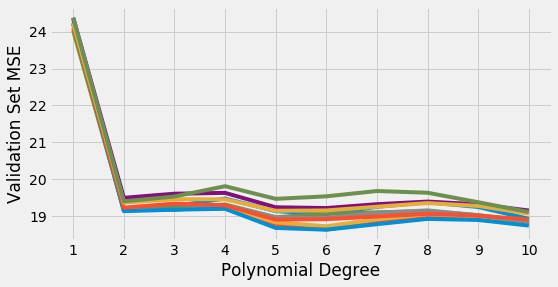

In [5]:
X = auto[["horsepower"]]
Y = auto[["mpg"]]

splits = 10
iterations = 10
max_degree = 10
errors = {num: list() for num in range(splits)}

for it in range(iterations):
    cv = KFold(n_splits = splits, shuffle = True, random_state = it)
    
    for j in range(1, max_degree + 1):
        poly_mse = list()
        
        for train_idx, test_idx in cv.split(X):
            X_train, X_test = np.array(X)[train_idx], np.array(X)[test_idx]
            Y_train, Y_test = np.array(Y)[train_idx], np.array(Y)[test_idx]
            X_train_poly = PolynomialFeatures(degree = j).fit_transform(X_train)
            X_test_poly = PolynomialFeatures(degree = j).fit_transform(X_test)
            model = LinearRegression().fit(X_train_poly, Y_train)
            poly_mse.append(
                mean_squared_error(Y_test, model.predict(X_test_poly)))
        errors[it].append(np.mean(poly_mse))

fig, ax = plt.subplots(figsize = (8, 4))
for i in range(splits):
    ax.plot(np.arange(1, max_degree + 1), errors[i])
plt.xticks(np.arange(1, 11))
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation Set MSE")
plt.show()

---

<a id="bias-variance-cv"></a>
## Bias-Variance Trade-Off for K-Fold Cross-Validation

Al di là dei vantaggi computazionali, un vantaggio importante del *KFold* è che spesso fornisce stime più accurate del *test error* rispetto alla *LOOCV*, e ciò dipende unicamente dal *bias-variance trade-off*.

Sappiamo che il *validation set approach* tende a sovrastimare il *test error*, perché addestra il modello solo su metà dataset; al contrario, la *LOOCV* fornisce una stima praticamente *unbiased* del *test error*, perché addestra il modello su quasi l'intero dataset. La *KFold*, invece, garantisce un livello intermedio di *bias*, in quanto il modello è addestrato a partire da un numero di osservazioni maggiore del *VSA* e minore della *LOOCV*.

Dal punto di vista del *bias*, quindi, la *LOOCV* è da preferire alla *KFold*. E' bene però tenere in considerazione anche la *varianza* della procedura, e non solo il suo bias. Vediamo perché la *LOOCV* è associata a molta più varianza della *KFold*: quando si implementa una *LOOCV* si sta calcolando una media di errori di $n$ modelli distinti, ognuno dei quali è stato addestrato con un dataset praticamente identico; pertanto, questi errori di cui fare la media sono altamente correlati gli uni con gli altri, e calcolare una media di quantità altamente correlate presenta molta più varianza rispetto al calcolo di una media di quantità non correlate.

La *KFold* calcola la media di soli $k$ errori, generati da modelli addestrati su dataset molto più diversificati. Questo ci permette di affermare che la stima prodotta dalla *KFold* è molto meno variabile di quella fornita dalla *LOOCV*.

Il parametro che governa questo *bias-variance trade-off* è chiaramente il coefficiente $k$ della generica *KFold*. I valori $k=5$ e $k=10$ si sono rivelati ideali per fornire stime del *test error* che non soffrono né di eccessivo bias né di eccessiva varianza.

---

<a id="cv-classification"></a>
## Cross-Validation on Classification Problems

Le tecniche di *cross-validation* sono facilmente estendibili anche ai task di classificazione. L'unica differenza è nelle metriche atomiche utilizzate: ad esempio, per quantificare il *test error*, si utilizza il numero di *misclassification*:

$$\large CV_{(k)}=\frac{1}{k}\sum_{i=1}^{k}Err_i$$

Spesso l'uso della *CV* è finalizzato a conoscere esattamente l'entità dell'errore che il modello compie nel predire i dati di test, così da poter confrontare fra loro modelli diversi e scegliere il più accurato.

In altri casi, invece, la *CV* è utilizzata per individuare il corretto valore di flessibilità/complessità da assegnare al *learning method*. In altre parole, non è tanto importante il valore esatto del *test error* restituito dal modello, quanto il grado di flessibilità ad esso associato che ha restituito il *test error* minore.

Nel plot che segue si mostra l'andamento del *validation error rate* di due modelli diversi: una regressione logistica e un *KNN*.

Entrambi gli *error rate* sono plottati in funzione del grado di flessibilità del corrispondente *learning method*: per la regressione logistica sono stati usati modelli polinomiali di grado crescente, mentre per il *KNN* si è semplicemente fatto variare l'iperparametro $K$.

Le curve arancioni evidenziano il *validation error*, mentre quelle blu il *training error*.

<img src="imgs/cv-classification.PNG"></img>

Possiamo notare come il *validation error* logistico evidenzi un minimo in corrispondenza del modello polinomiale di ordine tre, mentre il *validation error* del *KNN* risulta minimizzato per $K=10$.

---